In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Bidirectional, Concatenate, Softmax
import time
import pandas as pd
import os
import tqdm
import gensim.downloader
from sklearn.model_selection import train_test_split

In [3]:
def load_dataset(shard_ids):
    path = 'wikisum-en/nl2sl/web-only_v3/'
    x_files = []
    y_files = []
    title_files = []
    for shard_id in shard_ids:
        x_files.append("{}inputs.txt-{:05d}-of-01000".format(path, shard_id))
        y_files.append("{}outputs.txt-{:05d}-of-01000".format(path, shard_id))
        title_files.append("{}titles.txt-{:05d}-of-01000".format(path, shard_id))
    x = []
    y = []
    titles = []
    for i in range(len(x_files)):
        with open(x_files[i], 'r') as x_file:
            for line in x_file:
                x.append(line)
        with open(y_files[i], 'r') as y_file:
            for line in y_file:
                y.append(line)
        with open(title_files[i], 'r') as title_file:
            for line in title_file:
                titles.append(line)
    return x[:-1], y[:-1], titles[:-1]


dataset_shard_ids = [0]#i for i in range(45)]#0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]#, 1, 2, 3, 4, 5]
#val_shard_ids = [18, 19, 20]
natural_language_data, structured_langague_data, titles = load_dataset(dataset_shard_ids)

#x_val, y_val = load_dataset(val_shard_ids)


In [4]:
def limit_dataset(x, y, titles, max_words_per_statement):
    out_x = []
    out_y = []
    out_titles = []
    for i in range(len(x)):
        n_statements = len(y[i].split()) - 2
        n_tokens = len(x[i].split()) - 2
        n_title = len(titles[i].split())
        if(n_tokens + n_title <= 300 and n_statements <= 300):
            if float(n_tokens)/n_statements < max_words_per_statement:
                out_x.append(x[i].replace("\n", "").replace("\r", "").lower())
                out_y.append(y[i].replace("\n", "").replace("\r", "").lower())
                out_titles.append(titles[i].replace("\n", "").replace("\r", "").lower())
    return out_x, out_y, out_titles

limited_natural_language_data, limited_structured_langague_data, limited_titles = limit_dataset(natural_language_data, structured_langague_data, titles, 3)
print(len(limited_natural_language_data))
for i in range(20):
    print("{} {} -> {}".format(limited_titles[i], limited_natural_language_data[i], limited_structured_langague_data[i]))


2077
tyler haskins [ini-nl] check out tyler haskins profile on the official del website . [end-nl] -> [ini-sl] givenname tyler familyname haskins [end-sl]
jessica ettinger [ini-nl] don t cut jessica ! one woman pleaded . [end-nl] -> [ini-sl] givenname jessica sexorgender woman [end-sl]
persephone borrow [ini-nl] 89 . cambridge university press , cambridge . [end-nl] -> [ini-sl] educatedat cambridge university [end-sl]
rolf widerøe [ini-nl] wider e died on 11 october 1996 in switzerland , aged 94 . [end-nl] -> [ini-sl] dateofdeath 1996 / 10 / 11 [end-sl]
rolf widerøe [ini-nl] unfortunately no , rolf wider e is not alive anymore . the death rumors are true . [end-nl] -> [ini-sl] residence no countryofcitizenship no givenname rolf [end-sl]
rolf widerøe [ini-nl] rolf wider e was born in norway , oslo . [end-nl] -> [ini-sl] residence norway countryofcitizenship norway [end-sl]
rolf widerøe [ini-nl] rolf wider e attended rwth aachen university for academic studies . [end-nl] -> [ini-sl] educ

Distribuição de palavras na entrada (avaliacoes):


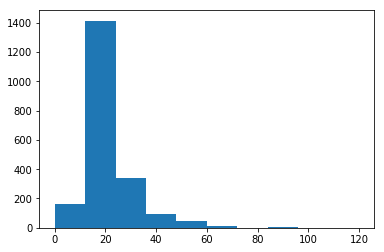

Distribuição de statements na saida


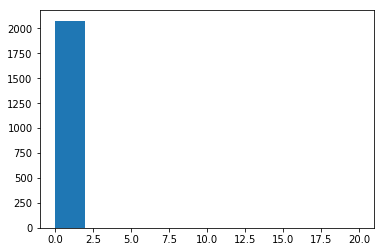

Distribuição de tokens na saida


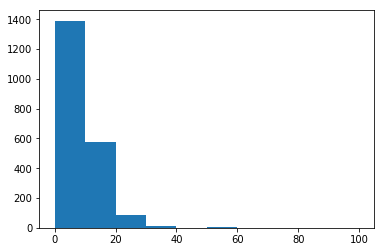

Distribuição de tokens na entrada/statements na saida


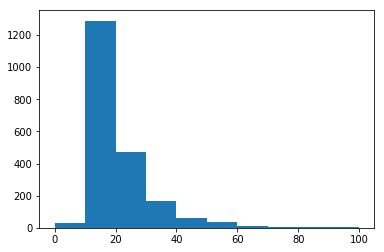

In [5]:
def show_distributions(x, y):
    # Distribuicao do numero de palavras nas avaliacoes e titulos
    print("Distribuição de palavras na entrada (avaliacoes):")
    plt.hist([len(linha.split()) for linha in x], range=(0, 120))
    plt.show()
    print("Distribuição de statements na saida")
    plt.hist([len(linha.split("SEP")) for linha in y], range=(0, 20))
    plt.show()
    print("Distribuição de tokens na saida")
    plt.hist([len(linha.split()) for linha in y], range=(0, 100))
    plt.show()
    print("Distribuição de tokens na entrada/statements na saida")
    statements = [len(linha.split("SEP")) for linha in y]
    tokens = [len(linha.split()) for linha in x]
    plt.hist([float(tokens[i])/statements[i] for i in range(len(x))], range=(0, 100))
    plt.show()

def joint_texts(a, b):
    out = []
    for i in range(len(a)):
        out.append(a[i]+ ' ' + b[i])
    return out

#show_distributions(natural_language_data, structured_langague_data)
x = joint_texts(limited_titles, limited_natural_language_data)
y = limited_structured_langague_data
show_distributions(x, y)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42, stratify=None)


In [6]:
print(len(x_train), len(x_val))


1765 312


In [7]:
def generate_vocab(sentences):
    vocab = {}
    index = 0
    for sentence in sentences:
        for word in sentence.split(' '):
            if(word not in vocab):
                vocab[word] = index
                index = index + 1
    return vocab

#vocab_dict = generate_vocab(x_train+y_train+x_val+y_val)
vocab_dict = generate_vocab(x_train+x_val+y_train+y_val)
vocab = [word for word in vocab_dict]
print(len(vocab))

6842


In [8]:
def create_tokenizers(vocab_size, max_input_size, max_output_size, words):
    # camada de tokenização
    input_vectorize_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=max_input_size, standardize=None)
    output_vectorize_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=max_output_size, standardize=None)
    # adapta tokenizador com entrada + saida + [MASC] (saida já tem <SOS> e <EOS>)
    input_vectorize_layer.adapt(words)
    output_vectorize_layer.adapt(words)
    vocab = input_vectorize_layer.get_vocabulary()
    word_index = dict(zip(vocab, range(len(vocab))))
    return input_vectorize_layer, output_vectorize_layer, vocab, word_index

VOCAB_SIZE = len(vocab)
MAXTOKENS_SL = 50# max([len(line.split()) for line in x_train]) # 200 # tamanho maximo considerado para textos
MAXTOKENS_NL = 100# max([len(line.split()) for line in y_train]) # 50
print(MAXTOKENS_NL, MAXTOKENS_SL)
input_tokenizer_layer, output_tokenizer_layer, tokenizer_vocab, word_index = create_tokenizers(VOCAB_SIZE, MAXTOKENS_NL, MAXTOKENS_SL, vocab)

# tokenizando dados de treino e validacao
input_tokenizer_model = tf.keras.models.Sequential()
input_tokenizer_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
input_tokenizer_model.add(input_tokenizer_layer)

output_tokenizer_model = tf.keras.models.Sequential()
output_tokenizer_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
output_tokenizer_model.add(output_tokenizer_layer)
'''
t_x_train = input_tokenizer_model.predict(x_train_limited)
t_x_val = input_tokenizer_model.predict(x_val_limited)
t_y_train = output_tokenizer_model.predict(y_train_limited)
t_y_val = output_tokenizer_model.predict(y_val_limited)
print(x_train_limited[0], '-->', t_x_train[0])
print(y_train_limited[0], '-->', t_y_train[0])
'''
t_x_train = input_tokenizer_model.predict(x_train)
t_x_val = input_tokenizer_model.predict(x_val)
t_y_train = output_tokenizer_model.predict(y_train)
t_y_val = output_tokenizer_model.predict(y_val)
print(x_train[0], '-->', t_x_train[0])
print(y_train[0], '-->', t_y_train[0])


100 50
matt marksberry [ini-nl] atlanta braves optioned lhp matt marksberry to mississippi braves . [end-nl] --> [2840 2873 6334 5937 5609 2306 3120 2840 2873  603 2688 5609 6751 6336
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[ini-sl] givenname matt familyname marksberry [end-sl] --> [6333 4035 2840 4367 2873 6335    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [9]:
# criando dataset do tipo tf.dataset (ja separado em batchs)]
BUFFER_SIZE_TRAIN = len(t_x_train)
BUFFER_SIZE_VAL = len(t_x_val)
BATCH_SIZE = 16
steps_per_epoch_train = len(t_x_train)//BATCH_SIZE
steps_per_epoch_val = len(t_x_val)//BATCH_SIZE
dataset_train = tf.data.Dataset.from_tensor_slices((t_x_train, t_y_train)).shuffle(BUFFER_SIZE_TRAIN)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)
# dataset de validacao
dataset_val = tf.data.Dataset.from_tensor_slices((t_x_val, t_y_val)).shuffle(BUFFER_SIZE_VAL)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset_train))
print(example_input_batch.shape, example_target_batch.shape)


(16, 100) (16, 50)


In [10]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

KeyboardInterrupt: 

In [ ]:
def create_embedding(word_index, pretrained_embedding, vocab_size, embedding_dim, max_sentence_size):
    hits = 0
    misses = 0
    # epecial tokens embeddings
    especial_tokens_emb = {}
    i = -2
    for especial_token in ['[SEP]','[END-NL]', '[INI-NL]', '[INI-SL]', '[END-SL]']:
        especial_tokens_emb[especial_token] = [float(i) for k in range(embedding_dim)]
        i = i + 1
    print(especial_tokens_emb)
    # Preparando embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    j = 0
    for word, i in word_index.items():
        if(word in pretrained_embedding):
            embedding_matrix[i] = pretrained_embedding[word]
            hits += 1
        elif word in ['[SEP]','[END-NL]', '[INI-NL]', '[INI-SL]', '[END-SL]']: # criando embedding padrao para tokens especiais
            embedding_matrix[i] = especial_tokens_emb[word]
            j = j + 1
            hits += 1
        else:
            misses += 1
    print("Hits: {}, misses: {}".format(hits, misses))
    print('Palavras {} convertidas ({} perdidas, {}%)'.format(hits, misses, round(100*misses/(hits+misses), 1)))
    print('Dims da matriz de embeddings: {}'.format(embedding_matrix.shape))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sentence_size, weights=[embedding_matrix], trainable=False)
    return embedding_layer, embedding_matrix

# camada de embedding
EMBEDDING_DIM = 100
embedding_layer, embedding_matrix = create_embedding(word_index, glove_vectors, VOCAB_SIZE, EMBEDDING_DIM, MAXTOKENS_NL)
print('Embedding de [SEP]', embedding_matrix[word_index['[SEP]']])# embeddings definidos para tokens especiais
print('Embedding de good: ', embedding_matrix[word_index['good']])# embeddings para tokens de algumas palavras


In [11]:
EMBEDDING_DIM = 50
embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAXTOKENS_NL, trainable=True)

In [12]:
class BiLSTMEncoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_layer, enc_units, batch_sz):
        super(BiLSTMEncoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = embedding_layer
        self.bilstm = Bidirectional(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(self.enc_units),
                                        return_sequences=True,
                                        return_state=True))

    def call(self, x, hidden):
        x = self.embedding(x)
        output, forward_h, forward_c, backward_h, backward_c =  self.bilstm(x, initial_state = hidden)
        return output, forward_h, forward_c, backward_h, backward_c

    def initialize_hidden_state(self):
        return [tf.zeros((self.batch_sz, self.enc_units)) for i in range(4)]
# encoder
units = 64
encoder = BiLSTMEncoder(VOCAB_SIZE, embedding_layer, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, forward_h, forward_c, backward_h, backward_c = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print('Encoder forward_h shape: (batch size, units) {}'.format(forward_h.shape))
print('Encoder forward_c shape: (batch size, units) {}'.format(forward_c.shape))
print('Encoder backward_h shape: (batch size, units) {}'.format(backward_h.shape))
print('Encoder backward_c shape: (batch size, units) {}'.format(backward_c.shape))
forward_backward_h = Concatenate(axis=1)([forward_h, backward_h])
print(forward_backward_h.shape)




Encoder output shape: (batch size, sequence length, units) (16, 100, 128)
Encoder forward_h shape: (batch size, units) (16, 64)
Encoder forward_c shape: (batch size, units) (16, 64)
Encoder backward_h shape: (batch size, units) (16, 64)
Encoder backward_c shape: (batch size, units) (16, 64)
(16, 128)


In [13]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# camada de atencao
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(forward_backward_h, sample_output)
print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))


Attention result shape: (batch size, units) (16, 128)
Attention weights shape: (batch_size, sequence_length, 1) (16, 100, 1)


In [15]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_layer, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = embedding_layer
        self.gru = tf.keras.layers.RNN(tf.keras.layers.GRUCell(self.dec_units),
                                        return_sequences=True,
                                        return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        print(x)
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        print(x.shape)
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        # output shape == (batch_size, vocab)
        x = self.fc(output)
        return x, state, attention_weights

# decoder
decoder = Decoder(VOCAB_SIZE, embedding_layer, 2*units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      forward_backward_h, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))


tf.Tensor(
[[0.1588713 ]
 [0.7435622 ]
 [0.03172994]
 [0.06415498]
 [0.5772766 ]
 [0.7692467 ]
 [0.8496237 ]
 [0.94352424]
 [0.37531805]
 [0.48972905]
 [0.3167323 ]
 [0.73157537]
 [0.13203096]
 [0.17736721]
 [0.07996702]
 [0.1921649 ]], shape=(16, 1), dtype=float32)
(16, 1, 50)
Decoder output shape: (batch_size, vocab size) (16, 6842)


In [ ]:
class PGDecoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_layer, dec_units, batch_sz):
        super(PGDecoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = embedding_layer
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                        return_sequences=True,
                                        return_state=True,
                                        recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        # used for attention
        self.attention = BahdanauAttention(self.dec_units)
        # pointer-generator generating probability
        self.p_gen_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        # generating probability
        # pgen input size == (batch_size, 1, state_size + embedding_dim + hidden_size)
        pgen = self.p_gen_layer(tf.concat([tf.expand_dims(state, 1), x], axis=-1))
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        # output shape == (batch_size, vocab)
        x = self.fc(output)
        x = pgen*output
        for i in range(len(enc_output)) + (1-pgen)*
        return x, state, attention_weights

# decoder
decoder = PGDecoder(VOCAB_SIZE, embedding_layer, 2*units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      forward_backward_h, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

In [13]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    mask2 = tf.cast(mask, dtype=tf.int32)
    predicted_ids = tf.argmax(pred, axis=1)
    matches = tf.cast(tf.math.equal(real, predicted_ids), dtype=tf.int32)
    matches *= mask2
    return tf.reduce_mean(loss_), tf.reduce_sum(matches)

In [14]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [15]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    matches = 0
    with tf.GradientTape() as tape:
        enc_output, enc_forward_h, enc_forward_c, enc_backward_h, enc_backward_c = encoder(inp, enc_hidden)
        dec_hidden = Concatenate(axis=1)([enc_forward_h, enc_backward_h])
        dec_input = tf.expand_dims([word_index['[ini-sl]']] * BATCH_SIZE, 1)
        #print(dec_input.shape, dec_hidden.shape)
        # Teacher forcing - feeding the target as the next input
        #print(targ.shape[1])
        for t in range(1, targ.shape[1]):
            #print(dec_hidden.shape)
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            new_loss, new_matches = loss_function(targ[:, t], predictions)
            loss += new_loss
            matches += new_matches
            #print(tf.cast(tf.math.equal(targ[:, t], predicted_ids), dtype=tf.int32))
            #print(matches)
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss, matches

@tf.function
def validation_step(inp, targ, enc_hidden):
    loss = 0
    enc_output, enc_forward_h, enc_forward_c, enc_backward_h, enc_backward_c = encoder(inp, enc_hidden)
    dec_hidden = Concatenate(axis=1)([enc_forward_h, enc_backward_h])
    dec_input = tf.expand_dims([word_index['[ini-sl]']] * BATCH_SIZE, 1)
    matches = 0
    #print(dec_input.shape, dec_hidden.shape)
    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
        #print(dec_hidden.shape)
        # passing enc_output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
        new_loss, new_matches = loss_function(targ[:, t], predictions)
        loss += new_loss
        matches += new_matches
        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)
    batch_loss = (loss / int(targ.shape[1]))
    return batch_loss, matches

In [23]:
N_WORDS_IN_OUTPUT_TRAIN = 0
for sentence in y_train:
    N_WORDS_IN_OUTPUT_TRAIN = N_WORDS_IN_OUTPUT_TRAIN + len(sentence.split()) - 2 # retirando tokens especiais [INI-SL] e [END-SL]
N_WORDS_IN_OUTPUT_VAL = 0
for sentence in y_val:
    N_WORDS_IN_OUTPUT_VAL = N_WORDS_IN_OUTPUT_VAL + len(sentence.split()) - 2 # retirando tokens especiais [INI-SL] e [END-SL]
print(N_WORDS_IN_OUTPUT_TRAIN, N_WORDS_IN_OUTPUT_VAL)

EPOCHS = 20
rouge = None
best_val_acc = 0.
history = {'epochs' : EPOCHS, 'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    train_matches = 0.
    for (batch, (inp, targ)) in enumerate(dataset_train.take(steps_per_epoch_train)):
        #print(inp.shape, targ.shape)
        batch_loss, new_matches = train_step(inp, targ, enc_hidden)
        train_matches = train_matches + new_matches.numpy()
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                        batch,
                                                        batch_loss.numpy()))
    total_loss_val = 0
    val_loss = 0
    validation_matches = 0.
    for (batch, (inp, targ)) in enumerate(dataset_val.take(steps_per_epoch_val)):
        batch_loss, new_matches = validation_step(inp, targ, enc_hidden)
        validation_matches = validation_matches + new_matches.numpy()
        total_loss_val += batch_loss
    # save checkpoint if acc in validation is better
    train_acc = train_matches / N_WORDS_IN_OUTPUT_TRAIN
    val_acc = validation_matches / N_WORDS_IN_OUTPUT_VAL
    if (val_acc > best_val_acc): # salvar apenas se o modelo tiver acuracia melhor na validacao
        print('Salving model with better validation accuracy: new acc. ({:.4f}) > last acc. ({:.4f})'.format(val_acc, best_val_acc))
        best_val_acc = val_acc
        checkpoint.save(file_prefix = checkpoint_prefix)
    print('Epoch {} | TRAIN: Loss {:.4f} Acc {:.4f} | VALIDATION: Loss {:.4f} Acc {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch_train, 
                                        train_acc,
                                        total_loss_val / steps_per_epoch_val, 
                                        val_acc))
    history['train_loss'].append(total_loss / steps_per_epoch_train)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(total_loss_val / steps_per_epoch_val)
    history['val_acc'].append(val_acc)    
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

628747 110488
Epoch 1 Batch 0 Loss 1.7887
Epoch 1 Batch 100 Loss 1.3244
Epoch 1 Batch 200 Loss 1.0622
Epoch 1 Batch 300 Loss 1.2964
Epoch 1 Batch 400 Loss 1.2078
Epoch 1 Batch 500 Loss 1.1668
Epoch 1 Batch 600 Loss 1.2142
Epoch 1 Batch 700 Loss 0.7861
Epoch 1 Batch 800 Loss 1.0241
Epoch 1 Batch 900 Loss 1.0273
Epoch 1 Batch 1000 Loss 0.8517
Epoch 1 Batch 1100 Loss 0.7963
Epoch 1 Batch 1200 Loss 0.9071
Epoch 1 Batch 1300 Loss 0.8191
Epoch 1 Batch 1400 Loss 0.8426
Epoch 1 Batch 1500 Loss 0.8370
Epoch 1 Batch 1600 Loss 1.0317
Epoch 1 Batch 1700 Loss 0.8417
Epoch 1 Batch 1800 Loss 0.7984
Epoch 1 Batch 1900 Loss 0.8811
Epoch 1 Batch 2000 Loss 1.2680
Epoch 1 Batch 2100 Loss 1.1422
Epoch 1 Batch 2200 Loss 0.6383
Epoch 1 Batch 2300 Loss 1.1417
Epoch 1 Batch 2400 Loss 0.7359
Epoch 1 Batch 2500 Loss 0.7515
Epoch 1 Batch 2600 Loss 0.6465
Epoch 1 Batch 2700 Loss 0.9037
Epoch 1 Batch 2800 Loss 0.9371
Epoch 1 Batch 2900 Loss 0.7797
Epoch 1 Batch 3000 Loss 0.6354
Epoch 1 Batch 3100 Loss 0.7576
Epoch 

Epoch 5 Batch 3900 Loss 0.3516
Epoch 5 Batch 4000 Loss 0.3340
Epoch 5 Batch 4100 Loss 0.3951
Epoch 5 Batch 4200 Loss 0.4037
Epoch 5 Batch 4300 Loss 0.4080
Epoch 5 Batch 4400 Loss 0.2177
Epoch 5 Batch 4500 Loss 0.3769
Epoch 5 Batch 4600 Loss 0.3759
Epoch 5 Batch 4700 Loss 0.1984
Epoch 5 Batch 4800 Loss 0.3026
Epoch 5 Batch 4900 Loss 0.2491
Salving model with better validation accuracy: new acc. (0.6212) > last acc. (0.5782)
Epoch 5 | TRAIN: Loss 0.3581 Acc 0.6455 | VALIDATION: Loss 0.4371 Acc 0.6212
Time taken for 1 epoch 3582.2522099018097 sec

Epoch 6 Batch 0 Loss 0.4408
Epoch 6 Batch 100 Loss 0.2164
Epoch 6 Batch 200 Loss 0.4822
Epoch 6 Batch 300 Loss 0.3605
Epoch 6 Batch 400 Loss 0.2012
Epoch 6 Batch 500 Loss 0.2651
Epoch 6 Batch 600 Loss 0.4850
Epoch 6 Batch 700 Loss 0.3708
Epoch 6 Batch 800 Loss 0.4478
Epoch 6 Batch 900 Loss 0.3188
Epoch 6 Batch 1000 Loss 0.2277
Epoch 6 Batch 1100 Loss 0.2350
Epoch 6 Batch 1200 Loss 0.2231
Epoch 6 Batch 1300 Loss 0.2815
Epoch 6 Batch 1400 Loss 0.4

Epoch 10 Batch 2100 Loss 0.2466
Epoch 10 Batch 2200 Loss 0.1580
Epoch 10 Batch 2300 Loss 0.2096
Epoch 10 Batch 2400 Loss 0.3155
Epoch 10 Batch 2500 Loss 0.0802
Epoch 10 Batch 2600 Loss 0.2680
Epoch 10 Batch 2700 Loss 0.1818
Epoch 10 Batch 2800 Loss 0.3097
Epoch 10 Batch 2900 Loss 0.1516
Epoch 10 Batch 3000 Loss 0.1799
Epoch 10 Batch 3100 Loss 0.1443
Epoch 10 Batch 3200 Loss 0.1675
Epoch 10 Batch 3300 Loss 0.1607
Epoch 10 Batch 3400 Loss 0.1731
Epoch 10 Batch 3500 Loss 0.1303
Epoch 10 Batch 3600 Loss 0.1291
Epoch 10 Batch 3700 Loss 0.1643
Epoch 10 Batch 3800 Loss 0.1285
Epoch 10 Batch 3900 Loss 0.1995
Epoch 10 Batch 4000 Loss 0.2994
Epoch 10 Batch 4100 Loss 0.1006
Epoch 10 Batch 4200 Loss 0.1869
Epoch 10 Batch 4300 Loss 0.2815
Epoch 10 Batch 4400 Loss 0.2296
Epoch 10 Batch 4500 Loss 0.0865
Epoch 10 Batch 4600 Loss 0.2248
Epoch 10 Batch 4700 Loss 0.1723
Epoch 10 Batch 4800 Loss 0.1262
Epoch 10 Batch 4900 Loss 0.0662
Salving model with better validation accuracy: new acc. (0.7288) > last 

Epoch 15 Batch 0 Loss 0.1023
Epoch 15 Batch 100 Loss 0.1134
Epoch 15 Batch 200 Loss 0.0342
Epoch 15 Batch 300 Loss 0.1413
Epoch 15 Batch 400 Loss 0.1209
Epoch 15 Batch 500 Loss 0.0900
Epoch 15 Batch 600 Loss 0.1340
Epoch 15 Batch 700 Loss 0.1037
Epoch 15 Batch 800 Loss 0.1001
Epoch 15 Batch 900 Loss 0.0797
Epoch 15 Batch 1000 Loss 0.1008
Epoch 15 Batch 1100 Loss 0.1071
Epoch 15 Batch 1200 Loss 0.1173
Epoch 15 Batch 1300 Loss 0.2147
Epoch 15 Batch 1400 Loss 0.0945
Epoch 15 Batch 1500 Loss 0.0627
Epoch 15 Batch 1600 Loss 0.0890
Epoch 15 Batch 1700 Loss 0.0598
Epoch 15 Batch 1800 Loss 0.0564
Epoch 15 Batch 1900 Loss 0.0953
Epoch 15 Batch 2000 Loss 0.0381
Epoch 15 Batch 2100 Loss 0.0729
Epoch 15 Batch 2200 Loss 0.1021
Epoch 15 Batch 2300 Loss 0.0504
Epoch 15 Batch 2400 Loss 0.0819
Epoch 15 Batch 2500 Loss 0.0987
Epoch 15 Batch 2600 Loss 0.1019
Epoch 15 Batch 2700 Loss 0.0992
Epoch 15 Batch 2800 Loss 0.0875
Epoch 15 Batch 2900 Loss 0.0735
Epoch 15 Batch 3000 Loss 0.0736
Epoch 15 Batch 3100 

Epoch 19 Batch 3200 Loss 0.0600
Epoch 19 Batch 3300 Loss 0.1194
Epoch 19 Batch 3400 Loss 0.1194
Epoch 19 Batch 3500 Loss 0.0294
Epoch 19 Batch 3600 Loss 0.0697
Epoch 19 Batch 3700 Loss 0.1061
Epoch 19 Batch 3800 Loss 0.0278
Epoch 19 Batch 3900 Loss 0.0808
Epoch 19 Batch 4000 Loss 0.0554
Epoch 19 Batch 4100 Loss 0.0852
Epoch 19 Batch 4200 Loss 0.0355
Epoch 19 Batch 4300 Loss 0.0794
Epoch 19 Batch 4400 Loss 0.1219
Epoch 19 Batch 4500 Loss 0.1430
Epoch 19 Batch 4600 Loss 0.0682
Epoch 19 Batch 4700 Loss 0.0497
Epoch 19 Batch 4800 Loss 0.1139
Epoch 19 Batch 4900 Loss 0.1022
Salving model with better validation accuracy: new acc. (0.7703) > last acc. (0.7673)
Epoch 19 | TRAIN: Loss 0.0762 Acc 0.9785 | VALIDATION: Loss 0.3651 Acc 0.7703
Time taken for 1 epoch 3582.4890904426575 sec

Epoch 20 Batch 0 Loss 0.0615
Epoch 20 Batch 100 Loss 0.0377
Epoch 20 Batch 200 Loss 0.0530
Epoch 20 Batch 300 Loss 0.0861
Epoch 20 Batch 400 Loss 0.0660
Epoch 20 Batch 500 Loss 0.0669
Epoch 20 Batch 600 Loss 0.070

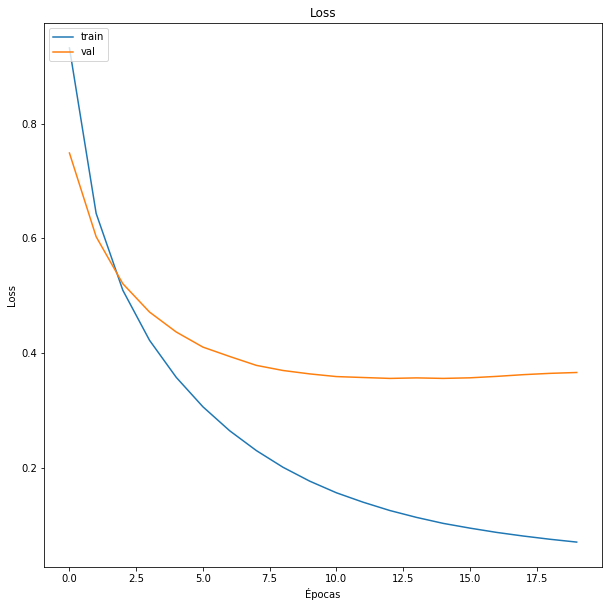

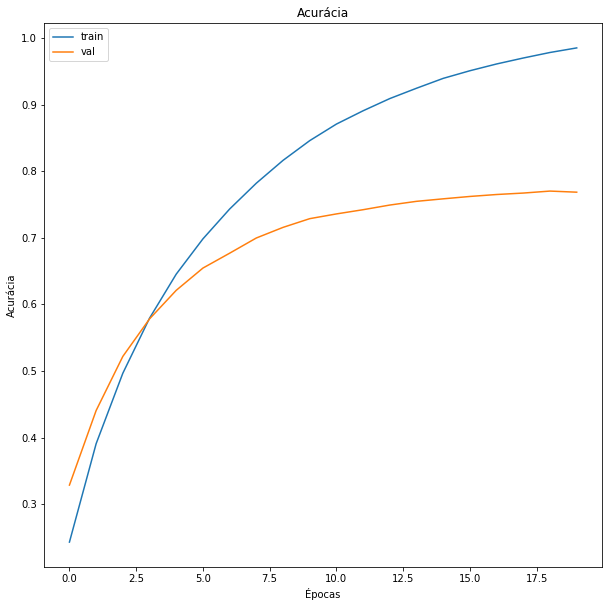

In [24]:
def plot_loss(history):
    plt.figure(figsize=(10, 10))
    plt.title('Loss')
    plt.plot(history['train_loss'], label='train')
    plt.plot(history['val_loss'], label='val')
    plt.ylabel('Loss')
    plt.xlabel('Épocas')
    plt.legend(loc=2)
    plt.show()

def plot_accuracy(history):
    plt.figure(figsize=(10, 10))
    plt.title('Acurácia')
    plt.plot(history['train_acc'], label='train')
    plt.plot(history['val_acc'], label='val')
    plt.ylabel('Acurácia')
    plt.xlabel('Épocas')
    plt.legend(loc=2)
    plt.show()

plot_loss(history)
plot_accuracy(history)

In [16]:
# recupera o ultimo modelo LSTM salvo (com a maior acuracia)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

def evaluate(sentence):
    attention_plot = np.zeros((MAXTOKENS_SL, MAXTOKENS_NL))
    #sentence = data_prep.preprocess_sentence(sentence)
    inputs = input_tokenizer_model.predict([sentence])
    n_sentences = len(inputs)
    inputs = Concatenate(axis=0)([inputs, tf.zeros((BATCH_SIZE - n_sentences, MAXTOKENS_NL), dtype=tf.dtypes.int64)])
    #print(inputs.shape)
    result = ''
    hidden = encoder.initialize_hidden_state()
    enc_output, enc_forward_h, enc_forward_c, enc_backward_h, enc_backward_c = encoder(inputs, hidden)
    dec_hidden = Concatenate(axis=1)([enc_forward_h, enc_backward_h])
    dec_input = tf.expand_dims([word_index['[ini-sl]']] * BATCH_SIZE, 1)
    result += '[ini-sl]' + ' '
    for t in range(MAXTOKENS_SL):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                            dec_hidden,
                                                            enc_output)
        #print(predictions)
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights[0], (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += tokenizer_vocab[predicted_id] + ' '
        if tokenizer_vocab[predicted_id] == '[end-sl]' or tokenizer_vocab[predicted_id] == '[end-nl]':
            return result, sentence, attention_plot
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id] * BATCH_SIZE, 1)
        #print(dec_input.shape)
    return result, sentence, attention_plot


In [44]:
x = "terry crews [ini-nl] terry crews is a former actor ( 1951 - 2020 ) [end-nl]"
natural_language_data_test, structured_langague_data_test, titles_test = load_dataset([47])
limited_natural_language_data_test, limited_structured_langague_data_test, limited_titles_test = limit_dataset(natural_language_data_test, structured_langague_data_test, titles_test, 3)
x_test = joint_texts(limited_titles_test, limited_natural_language_data_test)
for x in x_test:
    structured_language, natural_language, att = evaluate(x)
    print("Input: \n{}\n".format(natural_language))
    print("Output: \n{}\n\n".format(structured_language))


Input: 
keleswaram [ini-nl] keleswaram is a small village in thiruvananthapuram district in the state of kerala , india . [end-nl]

Output: 
[ini-sl] instanceof village locatedintheadministrativeterritorialentity thiruvananthapuram country india [end-sl] 


Input: 
keleswaram [ini-nl] culture of kerala temple procession in kanhangadpo . . . [end-nl]

Output: 
[ini-sl] instanceof band [end-sl] 


Input: 
atv: quad frenzy [ini-nl] atv quad frenzy is an off road racing game for the nintendo ds . [end-nl]

Output: 
[ini-sl] instanceof game publisher atari st wilson instanceof game publisher atari [end-sl] 


Input: 
atv: quad frenzy [ini-nl] atv quad frenzy is a nintendo ds four wheeler racing game . [end-nl]

Output: 
[ini-sl] instanceof game publisher atari st wilson developer feng office [end-sl] 


Input: 
atv: quad frenzy [ini-nl] atv quad frenzy is a nintendo ds four wheeler racing game . [end-nl]

Output: 
[ini-sl] instanceof game publisher atari st wilson developer feng office [end

Input: 
véronique sanson [ini-nl] the first thing that comes to mind when evoking french singer songwriter véronique sanson is her voice . [end-nl]

Output: 
[ini-sl] residence winnipeg occupation singer occupation voice [end-sl] 


Input: 
véronique sanson [ini-nl] listen to véronique sanson now . [end-nl]

Output: 
[ini-sl] employer bbc university [end-sl] 


Input: 
véronique sanson [ini-nl] french singer songwriter , musician , and producer , born 24 april 1949 , in boulogne , france . [end-nl]

Output: 
[ini-sl] occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer occupation singer 


Input: 
wuti [ini-nl] lp

Input: 
mike meyer [ini-nl] mike meyer kicking down hawkeye scoring marks iowa hawkeyes football qctimes . com [end-nl]

Output: 
[ini-sl] givenname theo familyname meyer sport football [end-sl] 


Input: 
mike meyer [ini-nl] scenes from the 2013 iowa hawkeyes football season . [end-nl]

Output: 
[ini-sl] memberofsportsteam washington redskins sport football [end-sl] 


Input: 
organisation (album) [ini-nl] most american music fans don t seem to know it , but orchestral manoeuvres in the dark were around long before . . . [end-nl]

Output: 
[ini-sl] performer mc hammer [end-sl] 


Input: 
organisation (album) [ini-nl] most american music fans don t seem to know it , but orchestral manoeuvres in the dark were around long before . . . [end-nl]

Output: 
[ini-sl] performer mc hammer [end-sl] 


Input: 
organisation (album) [ini-nl] organisation album songs orchestral manoeuvres in the dark omd mojim . com lyrics [end-nl]

Output: 
[ini-sl] instanceof album performer fabrizio sotti [end-sl

Input: 
grand theft auto: london 1969 [ini-nl] gta london 1961 1969 all radio stations rev . 1 [end-nl]

Output: 
[ini-sl] instanceof bank [end-sl] 


Input: 
grand theft auto: london 1969 [ini-nl] which renders its use in gta london 1961 anachronistic as the earliest songs are from 1967 . [end-nl]

Output: 
[ini-sl] instanceof london partof little rock horse [end-sl] 


Input: 
gomer jones [ini-nl] and before he was a football coach , gomer was a football player . one of the best ohio state ever had . [end-nl]

Output: 
[ini-sl] sport football league college basketball sport football league college basketball sport football league college basketball sport football league college basketball sport football league college basketball sport football league college basketball sport football league college basketball sport football league college basketball sport football league college basketball sport football league college basketball 


Input: 
gomer jones [ini-nl] gomer jones was born o

Input: 
s. w. r. d. bandaranaike [ini-nl] november 26th 1959 saw seven persons being charged in the chief magistrate s court of colombo on a charge of conspiring to murder swrd bandaranaike . they were [end-nl]

Output: 
[ini-sl] familyname hayden instanceof persons [end-sl] 


Input: 
sundara ramaswamy [ini-nl] copyright 2021 living media india limited . for reprint rights syndications today [end-nl]

Output: 
[ini-sl] country india countryofcitizenship india countryofcitizenship india [end-sl] 


Input: 
sundara ramaswamy [ini-nl] copyright 2021 harpercollins publishers india ltd . all rights reserved . [end-nl]

Output: 
[ini-sl] instanceof church of india [end-sl] 


Input: 
sundara ramaswamy [ini-nl] from india to u . s . a . [end-nl]

Output: 
[ini-sl] countryofcitizenship india countryofcitizenship india countryofcitizenship india [end-sl] 


Input: 
north killingholme [ini-nl] district governance is currently provided by the north lincolnshire council . [end-nl]

Output: 
[ini-

Input: 
edwin hofstetter [ini-nl] edwin hofstetter obituary chardon , ohio tributes . com [end-nl]

Output: 
[ini-sl] familyname artois placeofdeath linden [end-sl] 


Input: 
troy murphy [ini-nl] the golden state warriors have acquired forward troy murphy from the new jersey nets , along with the nets 2012 second round draft pick , in exchange for forward brandan wright and center dan gadzuric , the team announced today . [end-nl]

Output: 
[ini-sl] memberofsportsteam golden state warriors givenname bobby familyname quinn [end-sl] 


Input: 
troy murphy [ini-nl] ndmbb inside notre dame basketball episode 4 01 . 27 . 21 [end-nl]

Output: 
[ini-sl] familyname bank sport basketball [end-sl] 


Input: 
troy murphy [ini-nl] men s basketball ndmbb inside notre dame basketball episode 4 01 . 27 . 21 [end-nl]

Output: 
[ini-sl] sport basketball [end-sl] 


Input: 
troy murphy [ini-nl] men s basketball ndmbb inside notre dame basketball episode 4 01 . 27 . 21 [end-nl]

Output: 
[ini-sl] sport 

Input: 
annica svensson [ini-nl] marie laure delie of france and annica svensson of sweden battle for the ball during the women s football quarter final match between sweden and . . . [end-nl]

Output: 
[ini-sl] participantin tour de la sport football country sweden country france country france country france country france country france country france country france country france country france country france country france country france country france country france country france country france country france country france country france country france country france 


Input: 
annica svensson [ini-nl] gaetane thiney of france and annica svensson of sweden compete for the ball during the women s football quarter final match between sweden and . . . [end-nl]

Output: 
[ini-sl] country france country france country france country france country france country france country france country france country france country france country france country france country france country fr

Input: 
mike sylvester [ini-nl] we cannot survive unless our users help us . [end-nl]

Output: 
[ini-sl] countryofcitizenship us [end-sl] 


Input: 
mike sylvester [ini-nl] mike sylvester is a member of democratic socialists of america in maine . 1 [end-nl]

Output: 
[ini-sl] familyname dateofbirth 1931 / 01 / 24 [end-sl] 


Input: 
mike sylvester [ini-nl] endorsing democratic socialists of america members included mike sylvester , state representative , maine . [end-nl]

Output: 
[ini-sl] countryforsport america givenname mike placeofbirth chicago givenname mike placeofbirth chicago [end-sl] 


Input: 
mike sylvester [ini-nl] former university of dayton basketball standout mike sylvester seventh from left won a silver medal with italy in the 1980 olympics in moscow . sylvester was the lone american medalist . the united states boycotted those games . contributed photo [end-nl]

Output: 
[ini-sl] educatedat university of denver of national sexorgender m countryofcitizenship usa country

Input: 
frauenkappelen [ini-nl] for other uses , see bern disambiguation . [end-nl]

Output: 
[ini-sl] elevationabovesealevel + buscetta [end-sl] 


Input: 
frauenkappelen [ini-nl] bern is the capital city of switzerland . it is also the capital of the canton of bern . [end-nl]

Output: 
[ini-sl] elevationabovesealevel + chambliss [end-sl] 


Input: 
frauenkappelen [ini-nl] the town s website in german can be found here . [end-nl]

Output: 
[ini-sl] instanceof lighthouses locatedintheadministrativeterritorialentity la [end-sl] 


Input: 
church of all saints, campton [ini-nl] church of all saints , campton , bedfordshire . [end-nl]

Output: 
[ini-sl] instanceof church locatedintheadministrativeterritorialentity little rock [end-sl] 


Input: 
rognvald eysteinsson [ini-nl] rognvald was the son of eystein glumra ivarsson earl of upland and ascrida aseda rognvaldsdatter countess of oppland . he was born in norway and died in scotland . . [end-nl]

Output: 
[ini-sl] sibling indra lal roy f

Input: 
peter browne (rugby union) [ini-nl] former newcastle falcons and harlequins lock browne , 27 , has played for england students but is irish qualified . [end-nl]

Output: 
[ini-sl] memberofsportsteam england patriots positionplayedonteam/speciality point guard memberofsportsteam bradford park [end-sl] 


Input: 
mary catherine bateson [ini-nl] composing a further life by mary catherine bateson 9780307279637 penguinrandomhouse . com books [end-nl]

Output: 
[ini-sl] givenname mary givenname hazen familyname sullivan [end-sl] 


Input: 
mary catherine bateson [ini-nl] tippett that s a margaret mead quote . [end-nl]

Output: 
[ini-sl] givenname anthony familyname stone [end-sl] 


Input: 
introduction to the enemy [ini-nl] ipc films is jane fonda s production company . [end-nl]

Output: 
[ini-sl] instanceof movie [end-sl] 


Input: 
south northamptonshire (uk parliament constituency) [ini-nl] gps coordinates of south northamptonshire uk parliament constituency , united kingdom . la

Input: 
2011 fifa club world cup final [ini-nl] follow live minute by minute commentary of the fifa club world cup final between barcelona and santos in yokohama , japan , as lionel messi and neymar look to inspire their respective sides to the global crown . [end-nl]

Output: 
[ini-sl] sportsseasonofleagueorcompetition world series followedby 2015 of champions sport football location ottawa location ottawa location ottawa location ottawa location ottawa location ottawa location ottawa location ottawa location ottawa location ottawa location ottawa location ottawa location ottawa location ottawa location ottawa location ottawa location ottawa location ottawa location ottawa location ottawa location 


Input: 
altered carbon [ini-nl] preview altered carbon by richard k . morgan [end-nl]

Output: 
[ini-sl] numberofchildren + 5 [end-sl] 


Input: 
altered carbon [ini-nl] trivia about altered carbon t . . . [end-nl]

Output: 
[ini-sl] notablework felix to death wolf [end-sl] 


Input: 
alt

Input: 
dnm1 [ini-nl] de novo mutations in synaptic transmission genes including dnm1 cause epileptic encephalopathies . [end-nl]

Output: 
[ini-sl] haspart z bluegrass instanceof business [end-sl] 


Input: 
dnm1 [ini-nl] j 295898 xie aj , et al . , tau overexpression impairs neuronal endocytosis by decreasing the gtpase dynamin 1 through the mir 132 mecp2 pathway . aging cell . 2019 jun 18 3 e12929 [end-nl]

Output: 
[ini-sl] author taylor [end-sl] 


Input: 
daisy, princess of pless [ini-nl] the princess , known by her nickname daisy , was born at ruthin castle in denbighshire , wales , on june 28 , 1873 , the daughter of col . william cornwallis west and mary patsy fitzpatrick . [end-nl]

Output: 
[ini-sl] occupation priest givenname angela awardreceived mbe dateofbirth 1941 / 06 / 13 [end-sl] 


Input: 
1938 boston red sox season [ini-nl] 1938 boston red sox statistics baseball reference . com [end-nl]

Output: 
[ini-sl] seasonofcluborteam boston red sox sport baseball [end-sl] 



Input: 
leigh lawson [ini-nl] british film director mike leigh talks to mark lawson about his life and career . [end-nl]

Output: 
[ini-sl] occupation film depicts commander of st michael family [end-sl] 


Input: 
paul tergat [ini-nl] 17th june 1969 , riwo , baringo district , kenya . [end-nl]

Output: 
[ini-sl] partof the great smoky mountains for on the block [end-sl] 


Input: 
battle of powder river [ini-nl] copyright 2021 legends of america . all rights reserved [end-nl]

Output: 
[ini-sl] partof great war [end-sl] 


Input: 
benjamin g. wilkinson [ini-nl] who are similar persons to benjamin g . wilkinson ? [end-nl]

Output: 
[ini-sl] instanceof persons givenname benjamin familyname wilkinson [end-sl] 


Input: 
benjamin g. wilkinson [ini-nl] what is benjamin g . wilkinson doing now ? [end-nl]

Output: 
[ini-sl] givenname benjamin familyname wilkinson [end-sl] 


Input: 
albrecht behmel [ini-nl] more of albrecht behmel s favorite authors . . . [end-nl]

Output: 
[ini-sl] placeofd

Input: 
paul barrere [ini-nl] 16 people have seen paul barrere fred tackett live . [end-nl]

Output: 
[ini-sl] instanceof people givenname paul [end-sl] 


Input: 
alex cordaz [ini-nl] . . . niang was denied by an acrobatic effort from crotone shot stopper alex cordaz . [end-nl]

Output: 
[ini-sl] memberofsportsteam lowell spinners [end-sl] 


Input: 
sirpi balasubramaniam [ini-nl] first woman of india general konwledge important p . . . [end-nl]

Output: 
[ini-sl] countryofcitizenship india countryofcitizenship india countryofcitizenship india countryofcitizenship india countryofcitizenship india countryofcitizenship india countryofcitizenship india countryofcitizenship india countryofcitizenship india countryofcitizenship india countryofcitizenship india countryofcitizenship india countryofcitizenship india countryofcitizenship india countryofcitizenship india countryofcitizenship india countryofcitizenship india countryofcitizenship india countryofcitizenship india countryofcitizens

Input: 
charles steeb [ini-nl] acabamos de enviar um e mail de ativação para . [end-nl]

Output: 
[ini-sl] countryofcitizenship de nativelanguage de [end-sl] 


Input: 
charles steeb [ini-nl] marque a caixa de seleção eu não sou um robô . [end-nl]

Output: 
[ini-sl] countryofcitizenship de languagesspoken de [end-sl] 


Input: 
charles steeb [ini-nl] obrigado ! a sugestão de agrupamento foi submetida para revisão . [end-nl]

Output: 
[ini-sl] countryofcitizenship de [end-sl] 


Input: 
charles steeb [ini-nl] a solicitação de foto foi cumprida . [end-nl]

Output: 
[ini-sl] countryofcitizenship de nativelanguage de [end-sl] 


Input: 
charles steeb [ini-nl] arraste as imagens aqui ou selecione as de seu computador para o memorial charles w steeb . [end-nl]

Output: 
[ini-sl] presentinwork the weakerthans givenname charles givenname charles givenname charles givenname charles givenname charles givenname charles givenname charles givenname charles givenname charles givenname charles givenn

Input: 
jarret stoll [ini-nl] rangers agree to terms with free agent forward jarret stoll nhl . com [end-nl]

Output: 
[ini-sl] memberofsportsteam fc internazionale milano memberofsportsteam sporting kc [end-sl] 


Input: 
jarret stoll [ini-nl] jarret stoll stats and news nhl . com [end-nl]

Output: 
[ini-sl] familyname kozulin league nhl [end-sl] 


Input: 
febbre da cavallo - la mandrakata [ini-nl] olivia wilde and zoe lister jones interview each other about their sundance film how it ends . [end-nl]

Output: 
[ini-sl] instanceof single performer victory miss high street [end-sl] 


Input: 
febbre da cavallo - la mandrakata [ini-nl] can t find a movie or tv show ? login to create it . [end-nl]

Output: 
[ini-sl] instanceof single performer hide partof singer [end-sl] 


Input: 
eliphalet lockwood (deacon) [ini-nl] here lies the body of mr eliphalet lockwood who departed this life in the 78th year of his age , october 14th 1753 . [end-nl]

Output: 
[ini-sl] numberofchildren + 2 [end-s

Input: 
adamts13 [ini-nl] . these data suggest that multiple , physically separated regions of adamts13 are involved in the expression of its enzymatic activity . [end-nl]

Output: 
[ini-sl] languageofworkorname english [end-sl] 


Input: 
adamts13 [ini-nl] . among these cases , adamts13 activity level was normal or mildly decreased . thus , the decrease of adamts13 is specific for ttp . [end-nl]

Output: 
[ini-sl] encodes shp2 ortholog mcak [end-sl] 


Input: 
adamts13 [ini-nl] motto d , levy g , mcgee b , tsai hm , ginsburg d adamts13 mutations identified in familial ttp patients result in loss of vwf cleaving protease activity . [end-nl]

Output: 
[ini-sl] partof the usual suspects [end-sl] 


Input: 
adamts13 [ini-nl] tsai hm , sarode r , downes ka ultra large von willebrand factor multimers and normal adamts13 activity in the umbilical cord . [end-nl]

Output: 
[ini-sl] subclassof intensity calculatedfrom particle velocity [end-sl] 


Input: 
adamts13 [ini-nl] sava an s , lee sk ,

Input: 
hornsea wind farm [ini-nl] bladt industries has won a contract from dong energy to supply 96 transition pieces for the 1 . 2gw hornsea 1 offshore wind farm off the uk s east coast . [end-nl]

Output: 
[ini-sl] mainsubject cabinet and foundry [end-sl] 


Input: 
khutwajabdi [ini-nl] khutwajabdi is a town and village development committee in bara district in the narayani zone of south eastern nepal . [end-nl]

Output: 
[ini-sl] instanceof community bridge locatedintheadministrativeterritorialentity mustang [end-sl] 


Input: 
hrk (gene) [ini-nl] refseq mrnas for hrk gene nm 003806 . 2 [end-nl]

Output: 
[ini-sl] instanceof people [end-sl] 


Input: 
hrk (gene) [ini-nl] hot genes disease genes hrk gene at home site . [end-nl]

Output: 
[ini-sl] instanceof gene [end-sl] 


Input: 
hrk (gene) [ini-nl] the role of hrk gene in human cancer . [end-nl]

Output: 
[ini-sl] instanceof gene [end-sl] 


Input: 
hon sui sen [ini-nl] benedict hon sui sen b . 16 april 1916 , balik pulau , penan

Input: 
fgf7 [ini-nl] the protein core of the proteoglycan perlecan binds specifically to fibroblast growth factor 7 . [end-nl]

Output: 
[ini-sl] subclassof connective tissue studentof brad pitt [end-sl] 


Input: 
fgf7 [ini-nl] plac1 expression increases during trophoblast differentiation evidence for regulatory interactions with the fibroblast growth factor 7 fgf 7 axis . [end-nl]

Output: 
[ini-sl] encodes richard encodes cytidine deaminase [end-sl] 


Input: 
fgf7 [ini-nl] keratinocyte growth factor fibroblast growth factor 7 regulated cell migration and invasion through activation of nf kappab transcription factors . [end-nl]

Output: 
[ini-sl] subclassof radiometer receptor ortholog srprb [end-sl] 


Input: 
fgf7 [ini-nl] a functional variant alters binding of activating protein 1 regulating expression of fgf7 gene associated with chronic obstructive pulmonary disease . [end-nl]

Output: 
[ini-sl] encodes richard 1 instanceof gene [end-sl] 


Input: 
fgf7 [ini-nl] identification

Input: 
sept8 [ini-nl] cellular components containing sept8 protein from the compartments curated protein localization evidence scores dataset . [end-nl]

Output: 
[ini-sl] subclassof representedby culture encodes glen [end-sl] 


Input: 
sept8 [ini-nl] protein complexs containing sept8 protein from the corum protein complexes dataset . [end-nl]

Output: 
[ini-sl] subclassof martial arts [end-sl] 


Input: 
sept8 [ini-nl] cell lines with sept8 gene mutations from the cosmic cell line gene mutation profiles dataset . [end-nl]

Output: 
[ini-sl] encodes cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 


Input: 
sept8 [ini-nl] chemicals interacting with sept8 gene protein from the curated ctd gene che

Input: 
sept8 [ini-nl] histone modification site profiles with high histone modification abundance at sept8 gene from the roadmap epigenomics histone modification site profiles dataset . [end-nl]

Output: 
[ini-sl] instanceof database instanceof gene [end-sl] 


Input: 
sept8 [ini-nl] micrornas regulating expression of sept8 gene predicted using conserved mirna seed sequences from the targetscan predicted conserved microrna targets dataset . [end-nl]

Output: 
[ini-sl] encodes cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 ortholog cdc6 


Input: 
sept8 [ini-nl] micrornas regulating expression of sept8 gene predicted using nonconserved mirna seed sequences from the targetscan predicted nonconserved microrna tar

Input: 
jack flaherty [ini-nl] rhp jack flaherty assigned to palm beach cardinals from peoria chiefs . [end-nl]

Output: 
[ini-sl] givenname jack memberofsportsteam indianapolis school instanceof human [end-sl] 


Input: 
jack flaherty [ini-nl] rhp jack flaherty assigned to st . louis cardinals . [end-nl]

Output: 
[ini-sl] givenname jack memberofsportsteam cardinals [end-sl] 


Input: 
jack flaherty [ini-nl] rhp jack flaherty assigned to peoria chiefs from gcl cardinals . [end-nl]

Output: 
[ini-sl] givenname jack familyname oldham memberofsportsteam minnesota twins [end-sl] 


Input: 
jack flaherty [ini-nl] rhp jack flaherty assigned to gcl cardinals . [end-nl]

Output: 
[ini-sl] givenname jack familyname martínez memberofsportsteam cardinals [end-sl] 


Input: 
jack flaherty [ini-nl] st . louis cardinals signed rhp jack flaherty . [end-nl]

Output: 
[ini-sl] memberofsportsteam padres givenname jack familyname forde [end-sl] 


Input: 
aden, illinois [ini-nl] aden is 400 feet 122 m a

Input: 
bill kauffman [ini-nl] bill kauffman reason . com [end-nl]

Output: 
[ini-sl] causeofdeath heart [end-sl] 


Input: 
yury chaika [ini-nl] putin names career man as top prosecutor upi . com [end-nl]

Output: 
[ini-sl] sexorgender man [end-sl] 


Input: 
yury chaika [ini-nl] 2003 2021 the prosecutor general s office of the russian federation . all rights reserved [end-nl]

Output: 
[ini-sl] militarybranch imperial japanese militarybranch imperial japanese militarybranch british empire [end-sl] 


Input: 
yury chaika [ini-nl] 2003 2021 the prosecutor general s office of the russian federation . all rights reserved [end-nl]

Output: 
[ini-sl] militarybranch imperial japanese militarybranch imperial japanese militarybranch british empire [end-sl] 


Input: 
the marchers [ini-nl] with p olivier gourmet , tewfik jallab , vincent rottiers , m barek belkouk , nader boussandel , lubna azaal , hafsia herzi , charlotte le bon , francoise miquelis , philippe nahon , jamel debbouze . french 

Input: 
woolley's false antechinus [ini-nl] rory cooper s false antechinus p . roryi [end-nl]

Output: 
[ini-sl] partof six to midnight [end-sl] 


Input: 
woolley's false antechinus [ini-nl] woolley s false antechinus p . woolleyae [end-nl]

Output: 
[ini-sl] performer nikki grahame [end-sl] 


Input: 
mike woelfel [ini-nl] candidate profile mike woelfel news herald dispatch . com [end-nl]

Output: 
[ini-sl] givenname mike familyname curtis [end-sl] 


Input: 
mike woelfel [ini-nl] i m the first politician that says i ll raise your taxes . mike woelfel [end-nl]

Output: 
[ini-sl] sexorgender m occupation justice occupation basketball [end-sl] 


Input: 
william mure (scholar) [ini-nl] , ayrshire , on the 9th of july 1799 . [end-nl]

Output: 
[ini-sl] familyname page memberofsportsteam fiorentina [end-sl] 


Input: 
william mure (scholar) [ini-nl] for other people named william mure , see william mure disambiguation . [end-nl]

Output: 
[ini-sl] instanceof people familyname frank [end-

Input: 
harrison county, texas [ini-nl] copyright 2021 harrison county 200 west houston marshall , texas 903 935 8400 . all rights reserved . owa [end-nl]

Output: 
[ini-sl] rm locatedintheadministrativeterritorialentity washington county differentfrom harrison county differentfrom george harrison producer benjamin harrison county differentfrom george harrison producer benjamin harrison county differentfrom george harrison producer benjamin harrison county differentfrom george harrison producer benjamin harrison county differentfrom george harrison producer benjamin harrison county differentfrom george harrison producer benjamin harrison county differentfrom 


Input: 
harrison county, texas [ini-nl] james c . armstrong , history of harrison county , texas , 1839 1880 m . a . thesis , university of colorado , 1930 . randolph b . campbell , a southern community in crisis harrison county , texas , 1850 1880 austin texas state historical association , 1983 . [end-nl]

Output: 
[ini-sl] di

Input: 
harrison county, texas [ini-nl] copyright 2021 harrison county 200 west houston marshall , texas 903 935 8400 . all rights reserved . owa [end-nl]

Output: 
[ini-sl] rm locatedintheadministrativeterritorialentity washington county differentfrom harrison county differentfrom george harrison producer benjamin harrison county differentfrom george harrison producer benjamin harrison county differentfrom george harrison producer benjamin harrison county differentfrom george harrison producer benjamin harrison county differentfrom george harrison producer benjamin harrison county differentfrom george harrison producer benjamin harrison county differentfrom 


Input: 
rose (2014 film) [ini-nl] rose ajay rao , shravya in lead chitraloka . com kannada movie news , reviews image [end-nl]

Output: 
[ini-sl] countryoforigin in originallanguageoffilmortvshow hungarian countryoforigin in originallanguageoffilmortvshow hungarian countryoforigin in originallanguageoffilmortvshow hungarian coun

Input: 
natural high (frank gambale album) [ini-nl] all tracks written by frank gambale . [end-nl]

Output: 
[ini-sl] instanceof album [end-sl] 


Input: 
frank ivancie [ini-nl] ted wheeler i m running for mayor of portland oregonlive . com [end-nl]

Output: 
[ini-sl] sexorgender m occupation manager [end-sl] 


Input: 
kotchandpur upazila [ini-nl] is an upazila of jhenaidah district in the division of khulna , bangladesh . [end-nl]

Output: 
[ini-sl] locatedintheadministrativeterritorialentity nilphamari district country bangladesh [end-sl] 


Input: 
brian wimmer [ini-nl] brian wimmer was born on october 1 , 1959 in orem , utah , usa as brian l . wimmer . he is an actor and director , known for [end-nl]

Output: 
[ini-sl] familyname stewart dateofbirth 1966 / 10 / 01 placeofbirth naples countryofcitizenship usa [end-sl] 


Input: 
brian wimmer [ini-nl] brian wimmer is a 61 year old american actor . born brian l . wimmer on 1st october , 1959 in orem , utah , usa , he is famous for th

Input: 
2007 afc asian cup final [ini-nl] winner of the 2007 afc asian cup . [end-nl]

Output: 
[ini-sl] sportsseasonofleagueorcompetition european cup [end-sl] 


Input: 
copyright law of the united states [ini-nl] 17 u . s . code 303 duration of copyright works created but not published or copyrighted before january 1 , 1978 u . s . code us law lii legal information institute [end-nl]

Output: 
[ini-sl] appliestojurisdiction the united states [end-sl] 


Input: 
copyright law of the united states [ini-nl] 17 u . s . code 304 duration of copyright subsisting copyrights u . s . code us law lii legal information institute [end-nl]

Output: 
[ini-sl] appliestojurisdiction ct appliestojurisdiction us [end-sl] 


Input: 
copyright law of the united states [ini-nl] 28 u . s . code 1338 patents , plant variety protection , copyrights , mask works , designs , trademarks , and unfair competition u . s . code us law lii legal information institute [end-nl]

Output: 
[ini-sl] headquarterslocatio

Input: 
cyclic nucleotide-gated channel alpha 3 [ini-nl] the cnga3 gene is found on chromosome 2 . [end-nl]

Output: 
[ini-sl] instanceof season originalbroadcaster world turns instanceof season [end-sl] 


Input: 
cyclic nucleotide-gated channel alpha 3 [ini-nl] we report the identification of missense mutations in cnga3 in five families with rm 2 . [end-nl]

Output: 
[ini-sl] partof tomorrow comes country can [end-sl] 


Input: 
cyclic nucleotide-gated channel alpha 3 [ini-nl] cone photoreceptor cyclic nucleotide gated cng channels are thought to be tetrameric assemblies of cngb3 b3 and cnga3 a3 subunits 3 . [end-nl]

Output: 
[ini-sl] director jules robinson [end-sl] 


Input: 
cyclic nucleotide-gated channel alpha 3 [ini-nl] pcr rflp analysis and dna sequencing was applied for mutation screening of cnga3 and cngb3 1 . [end-nl]

Output: 
[ini-sl] instanceof firmware platform canon eos [end-sl] 


Input: 
cyclic nucleotide-gated channel alpha 3 [ini-nl] tissue specific expression of 

Input: 
search for beauty [ini-nl] tagged bradley page , buster crabbe , eddie gribbon , erle c . kenton , frank mcglynn sr . , gertrude michael , ida lupino , james b . pop kenton , james gleason , nora cecil , robert armstrong , roscoe karns , toby wing , virginia hammond [end-nl]

Output: 
[ini-sl] castmember ken memberof castmember joan crawford castmember john abbott castmember john abbott castmember john abbott castmember john abbott castmember john abbott castmember john abbott castmember john abbott castmember john abbott castmember john abbott castmember john abbott castmember john abbott castmember john abbott castmember john abbott castmember john abbott castmember john 


Input: 
lockheed c-130 hercules [ini-nl] 2021 lockheed martin aeronautics company . all rights reserved . [end-nl]

Output: 
[ini-sl] numberofdeaths + 30 [end-sl] 


Input: 
matt stonie [ini-nl] this joke would be better if matt stone wrote the movie . [end-nl]

Output: 
[ini-sl] givenname matt [end-sl] 



Input: 
companies act 2013 [ini-nl] no updates found in last 7 days . [end-nl]

Output: 
[ini-sl] country in [end-sl] 


Input: 
queen's wharf lighthouse [ini-nl] queen s wharf lighthouse toronto , ontario canada look out towers on waymarking . com [end-nl]

Output: 
[ini-sl] instanceof lighthouse locatedintheadministrativeterritorialentity on country canada [end-sl] 


Input: 
queen's wharf lighthouse [ini-nl] queen s wharf lighthouse toronto , ontario canada look out towers on waymarking . com [end-nl]

Output: 
[ini-sl] instanceof lighthouse locatedintheadministrativeterritorialentity on country canada [end-sl] 


Input: 
carry on (chris cornell album) [ini-nl] 2 . chris cornell loves them both . [end-nl]

Output: 
[ini-sl] performer bryan bryan [end-sl] 


Input: 
jason hill (american football) [ini-nl] jets sign wr jason hill , waive rookie safety antonio allen nj . com [end-nl]

Output: 
[ini-sl] positionplayedonteam/speciality wr givenname jason familyname hill [end-sl] 


Input

Input: 
trond fausa aurvåg [ini-nl] aurv g lives with his girlfriend , actress lena kristin ellingsen , in oslo . [end-nl]

Output: 
[ini-sl] screenwriter julien duvivier screenwriter mario haspart donkey kong haspart donkey kong haspart donkey kong haspart donkey kong haspart donkey kong haspart donkey kong haspart donkey kong haspart donkey kong haspart donkey kong haspart donkey kong haspart donkey kong haspart donkey kong haspart donkey kong haspart donkey kong haspart donkey kong 


Input: 
george ruddick [ini-nl] remembering life of george . [end-nl]

Output: 
[ini-sl] givenname george [end-sl] 


Input: 
glass: a portrait of philip in twelve parts [ini-nl] 2019 philip glass . all rights reserved . [end-nl]

Output: 
[ini-sl] mainsubject news of fine arts [end-sl] 


Input: 
glass: a portrait of philip in twelve parts [ini-nl] in july 2005 , filmmaker scott hicks started shooting a documentary about the composer philip glass to celebrate his 70th anniversary in 2007 . [end-nl]

O

Input: 
homayoun ershadi [ini-nl] before becoming an actor , he worked for several decades as an architect . [end-nl]

Output: 
[ini-sl] occupation lyricist occupation actor [end-sl] 


Input: 
the monster that challenged the world [ini-nl] giant mollusk monsters attack california . [end-nl]

Output: 
[ini-sl] publisher orange [end-sl] 


Input: 
the monster that challenged the world [ini-nl] seems a run of the mill variant on the 1950s atomic monster movie . [end-nl]

Output: 
[ini-sl] instanceof season [end-sl] 


Input: 
the monster that challenged the world [ini-nl] the film concerns an army of giant mollusks that emerge from california s salton sea . [end-nl]

Output: 
[ini-sl] color yellow [end-sl] 


Input: 
newton, south cambridgeshire [ini-nl] view details of the plan on the south cambridgeshire website . [end-nl]

Output: 
[ini-sl] instanceof street [end-sl] 


Input: 
koby maxwell [ini-nl] hi life sensation koby maxwell revealed ! ghanashowbiz . com [end-nl]

Output: 
[ini-s

Input: 
susan mitchell [ini-nl] dentons susan a . mitchell [end-nl]

Output: 
[ini-sl] givenname susan [end-sl] 


Input: 
aaron sandilands [ini-nl] aaron sandilands will play on at the dockers in 2018 . [end-nl]

Output: 
[ini-sl] familyname stone countryofcitizenship trinidad and tobago [end-sl] 


Input: 
aaron sandilands [ini-nl] high quality aaron sandilands continues to dominate . [end-nl]

Output: 
[ini-sl] givenname aaron familyname taylor [end-sl] 


Input: 
bolanle austen-peters [ini-nl] bolanle austen peters is a nigerian lawyer and businesswoman . [end-nl]

Output: 
[ini-sl] facetof elvis location scotland nextlowerrank [end-sl] 


Input: 
james canton [ini-nl] dr . james canton s recent forecasts . [end-nl]

Output: 
[ini-sl] givenname james placeofbirth la [end-sl] 


Input: 
oskar minkowski [ini-nl] was an undergraduate at the same time as minkowski . in [end-nl]

Output: 
[ini-sl] notablework love type me [end-sl] 


Input: 
oskar minkowski [ini-nl] , minkowski died sud

Input: 
đoko šalić [ini-nl] kerem kanter born april 29 , 1995 is a turkish basketball player . [end-nl]

Output: 
[ini-sl] dateofbirth 1986 / 04 / 29 sport basketball occupation basketball player [end-sl] 


Input: 
đoko šalić [ini-nl] lorenzo penna born january 21 , 1998 is an italian professional basketball player . [end-nl]

Output: 
[ini-sl] dateofbirth 1986 / 01 / 21 occupation basketball player [end-sl] 


Input: 
đoko šalić [ini-nl] lukas brazdauskis born october 1 , 1988 is a lithuanian professional basketball player . [end-nl]

Output: 
[ini-sl] dateofbirth 1991 / 10 / 14 sport basketball occupation basketball player [end-sl] 


Input: 
đoko šalić [ini-nl] miroslav pecarski born march 21 , 1967 is a serbian former basketball player . [end-nl]

Output: 
[ini-sl] dateofbirth 1986 / 03 / 21 sport basketball occupation basketball player [end-sl] 


Input: 
đoko šalić [ini-nl] neboj a zorki born 21 august 1961 is a former serbian basketball player . [end-nl]

Output: 
[ini-sl] date

Input: 
fndc5 [ini-nl] the extracellular domain is cleaved and released from the cell membrane . [end-nl]

Output: 
[ini-sl] partof 7 [end-sl] 


Input: 
pedro oliveira (swimmer) [ini-nl] pedro o , pedro cardoso , pedroa oliveira . . . [end-nl]

Output: 
[ini-sl] givenname pedro familyname booker [end-sl] 


Input: 
pedro oliveira (swimmer) [ini-nl] pedro oliveira was born in rio maior municipality . [end-nl]

Output: 
[ini-sl] familyname abbas placeofbirth soweto countryofcitizenship ireland [end-sl] 


Input: 
zelman cowen [ini-nl] when sir zelman cowen was sworn in as governor general of australia in 1977 he faced the problem of following the widely unpopular sir john kerr , although cowen was generally considered to be an excellent choice , partly because he had never been in politics . [end-nl]

Output: 
[ini-sl] differentfrom royal academy [end-sl] 


Input: 
zelman cowen [ini-nl] from 1967 to early 1970 , cowen was vice chancellor of the university of new england , and from mid 

Input: 
jean taittinger [ini-nl] portrait de jean taittinger , ministre de la justice , son bureau le 27 septetembre 1973 paris , france . [end-nl]

Output: 
[ini-sl] dateofbirth 1949 / 01 / 20 [end-sl] 


Input: 
jean taittinger [ini-nl] queen elizabeth ii meets the ambassador of the french republic mr jean pierre jouyet accompanied by mrs brigitte taittinger jouyet as he attends a . . . [end-nl]

Output: 
[ini-sl] father jean ii [end-sl] 


Input: 
jean taittinger [ini-nl] queen elizabeth ii meets the ambassador of the french republic mr jean pierre jouyet accompanied by mrs brigitte taittinger jouyet as he attends a . . . [end-nl]

Output: 
[ini-sl] father jean ii [end-sl] 


Input: 
jean taittinger [ini-nl] paris jean taittinger , a longtime french legislator and heir to the taittinger champagne legacy , died sunday . he was 89 . [end-nl]

Output: 
[ini-sl] sportsdisciplinecompetedin hammer throw givenname jim [end-sl] 


Input: 
târgu frumos [ini-nl] the predominant average hourly

Input: 
choristostigma zephyralis [ini-nl] genus choristostigma bugguide . net [end-nl]

Output: 
[ini-sl] parenttaxon ulmus minor [end-sl] 


Input: 
teddi king [ini-nl] teddi king was born on september 18 , 1929 in boston , massachusetts , usa as theodora king . she died on november 18 , 1977 . [end-nl]

Output: 
[ini-sl] dateofbirth 1906 / 09 / 18 placeofbirth boston countryofcitizenship usa dateofdeath 1991 / 11 / 18 placeofbirth boston countryofcitizenship usa dateofdeath 1991 / 11 / 18 placeofbirth boston countryofcitizenship usa dateofdeath 1991 / 11 / 18 placeofbirth boston countryofcitizenship usa dateofdeath 1991 / 11 / 18 placeofbirth boston countryofcitizenship usa 


Input: 
when michael calls [ini-nl] when michael calls also known as shattered silence is a 1972 thriller drama television movie directed by philip leacock and starring elizabeth ashley , ben gazzara and michael douglas . it was adapted from john farris 1967 novel of the same name . [end-nl]

Output: 
[ini-sl]

Input: 
malcolm geoffrey hilson [ini-nl] second secretary , foreign and commonwealth office . [end-nl]

Output: 
[ini-sl] educatedat toi whakaari [end-sl] 


Input: 
malcolm geoffrey hilson [ini-nl] first secretary , foreign and commonwealth office . [end-nl]

Output: 
[ini-sl] educatedat davis positionheld head of fame [end-sl] 


Input: 
malcolm geoffrey hilson [ini-nl] second secretary , foreign and commonwealth office . [end-nl]

Output: 
[ini-sl] educatedat toi whakaari [end-sl] 


Input: 
paul martin (scottish politician) [ini-nl] obituary paul martin , politician caught up in scandal . an appreciation heraldscotland [end-nl]

Output: 
[ini-sl] givenname paul familyname martin occupation politician [end-sl] 


Input: 
paul martin (scottish politician) [ini-nl] obituary paul martin , politician caught up in scandal . an appreciation [end-nl]

Output: 
[ini-sl] givenname paul familyname martin occupation politician [end-sl] 


Input: 
paul martin (scottish politician) [ini-nl] obit

Input: 
bart bassett [ini-nl] londonderry mp bart bassett i reject this allegation . [end-nl]

Output: 
[ini-sl] characters john characters dk [end-sl] 


Input: 
jack whitham [ini-nl] born in burnley , jack made his reputation at sheffield wednesday , for whom he scored 26 times in 63 league games , as well as appearing once for england s under 23 side . [end-nl]

Output: 
[ini-sl] placeofbirth romford memberofsportsteam new york knicks [end-sl] 


Input: 
jack whitham [ini-nl] jack whitham league appearances . liverpool fc [end-nl]

Output: 
[ini-sl] memberofsportsteam liverpool football club [end-sl] 


Input: 
jack whitham [ini-nl] jack whitham liverpool fc league appearances . [end-nl]

Output: 
[ini-sl] memberofsportsteam liverpool memberofsportsteam liverpool [end-sl] 


Input: 
paul dirac [ini-nl] paul a . m . dirac died on october 20 , 1984 . [end-nl]

Output: 
[ini-sl] sexorgender m familyname namedafter george cross [end-sl] 


Input: 
taft museum of art [ini-nl] 2020 taft m

Input: 
shuva (film) [ini-nl] , chashi nazrul islam and sujata . [end-nl]

Output: 
[ini-sl] instanceof movie [end-sl] 


Input: 
perm academic theatre [ini-nl] the area in front of the perm academic theatre theatre . [end-nl]

Output: 
[ini-sl] instanceof journal country in [end-sl] 


Input: 
emanuele birarelli [ini-nl] born in senigallia an on 8th february 1981 . height 202 . middle blocker . [end-nl]

Output: 
[ini-sl] placeofbirth venice placeofdeath zurich [end-sl] 


Input: 
fabiano caruana [ini-nl] 1 2 . caruana fabiano ita 2775 and karjakin sergey rus 2779 6 . 0 3 6 . ponomariov ruslan ukr 2726 , kramnik vladimir rus 2799 , naiditsch arkadij ger 2700 and leko peter hun 2730 5 . 5 7 . meier georg ger 2644 4 . 0 8 . fridman daniel ger 2655 3 . 5 9 . bartel mateusz pol 2674 2 . 0 10 . gustafsson jan ger 2629 1 . 5 [end-nl]

Output: 
[ini-sl] givenname fabiano countryofcitizenship myanmar [end-sl] 


Input: 
fabiano caruana [ini-nl] copyright 2007 2015 united states chess federati

Input: 
siler city municipal airport [ini-nl] surveyed elevation is 615 feet msl . [end-nl]

Output: 
[ini-sl] elevationabovesealevel + 1 metre [end-sl] 


Input: 
siler city municipal airport [ini-nl] karen mccraw 80 aviation dr . siler city , nc 27344 phone 919 742 3847 [end-nl]

Output: 
[ini-sl] performer iron maiden performer iron maiden performer iron maiden performer iron maiden performer iron maiden performer iron maiden performer iron maiden performer iron maiden performer iron maiden performer iron maiden performer iron maiden performer iron maiden performer iron maiden performer iron maiden performer iron maiden performer iron maiden performer iron 


Input: 
siler city municipal airport [ini-nl] flying to siler city municipal airport ? find the distance to fly . [end-nl]

Output: 
[ini-sl] placeservedbytransporthub traverse city instanceof airport [end-sl] 


Input: 
siler city municipal airport [ini-nl] for private jet charter to or from siler city municipal airport call v

Input: 
ekaterina birlova [ini-nl] larissa franca maestrini and talita rocha of brazil in action against ekaterina birlova of russia during the women s beach volleyball preliminary . . . [end-nl]

Output: 
[ini-sl] countryofcitizenship mauritius countryforsport russia sexorgender women sport chess [end-sl] 


Input: 
ekaterina birlova [ini-nl] shauna mullin of great britain blocks ekaterina khomyakova of russia during the women s beach volleyball preliminary match between great britain and . . . [end-nl]

Output: 
[ini-sl] countryofcitizenship great britain [end-sl] 


Input: 
ekaterina birlova [ini-nl] russia s ekaterina birlova and evgenia ukolova celebrate celebrate after winning the women s beach volleyball round of 16 match between russia and . . . [end-nl]

Output: 
[ini-sl] countryofcitizenship france familyname dragun sexorgender women [end-sl] 


Input: 
ekaterina birlova [ini-nl] larissa franca maestrini of brazil in action against ekaterina birlova of russia during the women

Input: 
pembroke airport [ini-nl] elevation is 532 feet msl . [end-nl]

Output: 
[ini-sl] elevationabovesealevel + 0 [end-sl] 


Input: 
jeremiah ogbodo [ini-nl] he was born and raised in lagos , nigeria . [end-nl]

Output: 
[ini-sl] placeofbirth bismarck countryofcitizenship nigeria [end-sl] 


Input: 
stephan winkelmann [ini-nl] 7 minutes in heaven with stephan winkelmann , ceo of lamborghini . a haute interview haute living [end-nl]

Output: 
[ini-sl] givenname rupert familyname winkelmann memberof death [end-sl] 


Input: 
stephan winkelmann [ini-nl] 7 minutes in heaven with stephan winkelmann , ceo of lamborghini . a haute interview [end-nl]

Output: 
[ini-sl] givenname bruno familyname winkelmann memberof shetland [end-sl] 


Input: 
hayden island, portland, oregon [ini-nl] 2021 portland neighborhood guide . [end-nl]

Output: 
[ini-sl] locatedintheadministrativeterritorialentity portland instanceof records [end-sl] 


Input: 
tara reid [ini-nl] tara reid calls off wedding people 

Input: 
mega man iii (game boy) [ini-nl] this article is about the game boy game . for the nes game , see mega man 3 . [end-nl]

Output: 
[ini-sl] partoftheseries mega man china partoftheseries mega man china platform wii platform wii platform wii platform wii platform wii platform wii platform wii platform wii platform wii platform wii platform wii platform wii platform wii platform wii platform wii platform wii platform wii platform wii platform wii platform wii platform wii 


Input: 
mega man iii (game boy) [ini-nl] mega man 2 3 4 5 6 7 8 9 10 11 mega man dr . wily s revenge mega man ii iii iv v mega man bass [end-nl]

Output: 
[ini-sl] partoftheseries mega man characters mega man characters mega man characters mega man characters mega man characters mega man characters mega man characters mega man characters mega man characters mega man characters mega man characters mega man characters mega man characters mega man characters mega man characters mega man characters mega 


Input: 

Input: 
miss earth dr congo [ini-nl] new miss earth d . r . of congo christelle lohembe [end-nl]

Output: 
[ini-sl] followedby libya [end-sl] 


Input: 
miss earth dr congo [ini-nl] new miss earth d . r . of congo christelle lohembe [end-nl]

Output: 
[ini-sl] followedby libya [end-sl] 


Input: 
miss earth dr congo [ini-nl] new miss earth d . r . of congo christelle lohembe [end-nl]

Output: 
[ini-sl] followedby libya [end-sl] 


Input: 
miss earth dr congo [ini-nl] re new miss earth d . r . of congo christelle lohembe [end-nl]

Output: 
[ini-sl] followedby real time [end-sl] 


Input: 
miss earth dr congo [ini-nl] re new miss earth d . r . of congo christelle lohembe [end-nl]

Output: 
[ini-sl] followedby real time [end-sl] 


Input: 
miss earth dr congo [ini-nl] christelle lohembe miss earth dr congo . . . miss earth fan club facebook [end-nl]

Output: 
[ini-sl] followedby the real in [end-sl] 


Input: 
dave ogilvie [ini-nl] nine inch nails dave rave ogilvie nin . wiki [end-nl]

Ou

Input: 
daniel leadbitter [ini-nl] sky sports understands a number of football league clubs are tracking hereford defender daniel leadbitter . [end-nl]

Output: 
[ini-sl] sport football memberofsportsteam raith rovers positionplayedonteam/speciality midfielder givenname daniel familyname frimpong [end-sl] 


Input: 
lepiota ignivolvata [ini-nl] taxid 255058 lepiota discolorata species , lepiota discolorata cleland synonym . [end-nl]

Output: 
[ini-sl] iucnconservationstatus vulnerable taxonrank species [end-sl] 


Input: 
pitfall! [ini-nl] concept art for the hero of david crane s new game , jungleventure . [end-nl]

Output: 
[ini-sl] castmember david cronenberg [end-sl] 


Input: 
pitfall! [ini-nl] on friday , activision published its own pitfall ! game for ios , produced without crane s involvement . [end-nl]

Output: 
[ini-sl] castmember adam pally castmember arshad warsi [end-sl] 


Input: 
pasquale esposito (actor) [ini-nl] pasquale esposito was born on may 26 , 1963 in italy . he

Input: 
kimberly mcdonald [ini-nl] 2021 kimberly mcdonald . all rights reserved . [end-nl]

Output: 
[ini-sl] givenname kimberly familyname hall givenname subsidiary familyname jones [end-sl] 


Input: 
kimberly mcdonald [ini-nl] stars celebrate jewelry designer kimberly mcdonald people . com [end-nl]

Output: 
[ini-sl] givenname kimberly familyname hall instanceof people [end-sl] 


Input: 
kimberly mcdonald [ini-nl] 2021 kimberly mcdonald . all rights reserved . [end-nl]

Output: 
[ini-sl] givenname kimberly familyname hall givenname subsidiary familyname jones [end-sl] 


Input: 
james ross (canadian businessman) [ini-nl] james ross died on the 20th of september 1913 , which was a saturday . the tragic death occurred 107 years ago . [end-nl]

Output: 
[ini-sl] familyname martin dateofdeath 1983 / 09 / 20 [end-sl] 


Input: 
james ross (canadian businessman) [ini-nl] james ross was born in cromarty , scotland . [end-nl]

Output: 
[ini-sl] givenname james placeofbirth singapore [end-s

Input: 
saucy sylvia [ini-nl] saucy sylvia was born in canada , ontario . [end-nl]

Output: 
[ini-sl] placeofbirth canada placeofbirth canada [end-sl] 


Input: 
saucy sylvia [ini-nl] are persons that are similar to saucy sylvia . click on their names to check out their faqs . [end-nl]

Output: 
[ini-sl] haspart jonathan trumbull [end-sl] 


Input: 
saucy sylvia [ini-nl] saucy sylvia recites spoonerisms on 1955 television show . video dailymotion [end-nl]

Output: 
[ini-sl] castmember kaoru kobayashi castmember vikram chandra familyname khan familyname gohar [end-sl] 


Input: 
jolly jam [ini-nl] appspy ios game news and video reviews . [end-nl]

Output: 
[ini-sl] platform os [end-sl] 


Input: 
richard baker (game designer) [ini-nl] richard baker was born in florida , united states . [end-nl]

Output: 
[ini-sl] dateofbirth 1923 / 01 / 20 placeofdeath louisiana [end-sl] 


Input: 
richard baker (game designer) [ini-nl] see richard baker s home page here . [end-nl]

Output: 
[ini-sl] gi

Input: 
philoctetes (sophocles play) [ini-nl] now , my son , when philoctetes begins to tell you his sorry tale , listen to him and grab what parts of it suits your own purpose . [end-nl]

Output: 
[ini-sl] partof the life to death [end-sl] 


Input: 
philoctetes (sophocles play) [ini-nl] chorus listens carefully to the noise philoctetes is making as he is dragging his sore leg . [end-nl]

Output: 
[ini-sl] performer danny hunt familyname addams [end-sl] 


Input: 
philoctetes (sophocles play) [ini-nl] enter philoctetes , unkempt , dirty , limping badly , agony in his face with his every step . [end-nl]

Output: 
[ini-sl] performer black moth super rainbow [end-sl] 


Input: 
philoctetes (sophocles play) [ini-nl] i agree with what you say about that ruffian odysseus and about the atreus brothers , philoctetes ! i know from personal experience just how evil they all are . [end-nl]

Output: 
[ini-sl] performer dave williams [end-sl] 


Input: 
philoctetes (sophocles play) [ini-nl] he , t

Input: 
floyd west [ini-nl] find floyd west at legacy . com [end-nl]

Output: 
[ini-sl] author paul reubens [end-sl] 


Input: 
floyd west [ini-nl] listen to floyd west now . [end-nl]

Output: 
[ini-sl] performer white records [end-sl] 


Input: 
fancy (band) [ini-nl] the band fancy developed from session work . [end-nl]

Output: 
[ini-sl] instanceof band instanceof band [end-sl] 


Input: 
fancy (band) [ini-nl] listen to the nuttin fancy band now . [end-nl]

Output: 
[ini-sl] instanceof album recordlabel ecm instanceof band [end-sl] 


Input: 
muhammad el-amin [ini-nl] muhammad el amin college stats college basketball at sports reference . com [end-nl]

Output: 
[ini-sl] occupation politician sport basketball [end-sl] 


Input: 
patrick sheehan (oregon politician) [ini-nl] patrick sheehan is a former republican member of the oregon house of representatives , representing district 51 from 2011 to 2013 . [end-nl]

Output: 
[ini-sl] positionheld member of the texas house of representativ

Input: 
slots-a-fun casino [ini-nl] wildfire casino north las vegas replaces ernie s casino . [end-nl]

Output: 
[ini-sl] instanceof hotel use hotel instanceof casino use casino [end-sl] 


Input: 
slots-a-fun casino [ini-nl] nob hill closes to reopen in 1992 as casino royale . [end-nl]

Output: 
[ini-sl] performer vinnie moore [end-sl] 


Input: 
slots-a-fun casino [ini-nl] holiday casino opens , later to become harrah s . [end-nl]

Output: 
[ini-sl] instanceof casino use hotel instanceof hotel use hotel instanceof hotel use hotel instanceof hotel use hotel instanceof hotel use hotel instanceof hotel use hotel instanceof hotel use hotel instanceof hotel use hotel instanceof hotel use hotel instanceof hotel use hotel instanceof hotel use hotel instanceof hotel use hotel instanceof hotel 


Input: 
slots-a-fun casino [ini-nl] bonanza casino opens at what would later be bally s . [end-nl]

Output: 
[ini-sl] copyrightholder microsoft differentfrom citigroup location it [end-sl] 


Input: 

Input: 
rafael márquez [ini-nl] hellas verona have secured the services of veteran mexico defender rafael marquez on undisclosed terms . [end-nl]

Output: 
[ini-sl] memberofsportsteam afc telford positionplayedonteam/speciality defender givenname rafael memberofsportsteam telford givenname aberdeen [end-sl] 


Input: 
rafael márquez [ini-nl] html public w3c dtd xhtml 1 . 0 transitional en www . w3 . org tr xhtml1 dtd xhtml1 transitional . dtd [end-nl]

Output: 
[ini-sl] totalgoalsincareer + 0 [end-sl] 


Input: 
rafael márquez [ini-nl] at the 2006 world cup in germany , marquez played in all three of mexico s group matches and scored the goal in their 2 1 loss to argentina in the second round . [end-nl]

Output: 
[ini-sl] countryforsport germany countryofcitizenship sweden [end-sl] 


Input: 
rafael márquez [ini-nl] marquez scored in their 1 1 draw with the hosts and assisted in javier hernandez s strike in the 2 0 win over france , before mexico were once again eliminated by argentina

Input: 
david christie (singer) [ini-nl] french pop singer , songwriter and multi instrumentalist . january 1st 1948 may 14th 1997 [end-nl]

Output: 
[ini-sl] genre pop occupation singer occupation singer awardreceived world turns [end-sl] 


Input: 
david christie (singer) [ini-nl] david christie singer , songwriter , composer , record producer and musician . [end-nl]

Output: 
[ini-sl] familyname jones occupation songwriter occupation musician occupation musician occupation musician occupation musician occupation musician occupation musician occupation musician occupation musician occupation musician occupation musician occupation musician occupation musician occupation musician occupation musician occupation musician occupation musician occupation musician occupation musician occupation musician occupation musician occupation musician occupation musician occupation musician 


Input: 
david christie (singer) [ini-nl] follow david christie international fan page on wordpress . com [e

Input: 
bruce schneier [ini-nl] sidebar photo of bruce schneier by joe macinnis . [end-nl]

Output: 
[ini-sl] givenname bruce familyname evans [end-sl] 


Input: 
bruce schneier [ini-nl] sidebar photo of bruce schneier by joe macinnis . [end-nl]

Output: 
[ini-sl] givenname bruce familyname evans [end-sl] 


Input: 
bruce schneier [ini-nl] sidebar photo of bruce schneier by joe macinnis . [end-nl]

Output: 
[ini-sl] givenname bruce familyname evans [end-sl] 


Input: 
djamel laroussi [ini-nl] algerian singer , composer , songwriter , arranger and guitar player . [end-nl]

Output: 
[ini-sl] occupation musician occupation musician occupation organ teacher occupation musician occupation organ teacher occupation musician occupation organ teacher occupation musician occupation organ teacher occupation musician occupation organ teacher occupation musician occupation organ teacher occupation musician occupation organ teacher occupation musician occupation organ teacher occupation musician occ

Input: 
bratislava airport [ini-nl] . airport bratislava . sk your gateway to europe . [end-nl]

Output: 
[ini-sl] instanceof airport locatedintheadministrativeterritorialentity east delhi locatedintheadministrativeterritorialentity eldoret locatedintheadministrativeterritorialentity east delhi [end-sl] 


Input: 
bratislava airport [ini-nl] welcome to the airport bratislava . sk [end-nl]

Output: 
[ini-sl] instanceof airport [end-sl] 


Input: 
bratislava airport [ini-nl] welcome to the website of airport of bratislava . [end-nl]

Output: 
[ini-sl] instanceof airport [end-sl] 


Input: 
cornelius low house [ini-nl] cornelius low house middlesex county museum piscataway nj aaa . com [end-nl]

Output: 
[ini-sl] instanceof high school locatedintheadministrativeterritorialentity tx [end-sl] 


Input: 
lester lautenschlaeger [ini-nl] long before the new orleans saints came along , lester lautenschlaeger brought professional football to new orleans . [end-nl]

Output: 
[ini-sl] memberofspor

In [18]:
for x in x_val[200:210]:
    structured_language, natural_language, att = evaluate(x)
    print("Input: \n{}\n".format(natural_language))
    print("Output: \n{}\n\n".format(structured_language))


Input: 
stambp [ini-nl] clathrin anchors deubiquitinating enzymes , amsh and amsh like protein , on early endosomes . [end-nl]

Output: 
[ini-sl] encodes stambp ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh ortholog amsh 


Input: 
fever tree (album) [ini-nl] listen to fever tree now . [end-nl]

Output: 
[ini-sl] performer adele performer [end-sl] 


Input: 
aviv geffen [ini-nl] interview with aviv geffen and steven wilson at rockline . it [end-nl]

Output: 
[ini-sl] givenname aviv familyname geffen [end-sl] 


Input: 
manuela ímaz [ini-nl] manuela ímaz born manuela eugenia ímaz houglín june 14 , 1979 is a mexican actress , born in chilpancingo , guerrero , mexico . [end-nl]

Output: 
[ini-sl] givenname manuela dat